# • Probabilistic Forecast Evaluation

> Hierarchical Forecast's reconciliation and evaluation.

This notebook offers a step to step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `HierarchicalForecast` and `StatsForecast` core class, to create base predictions, reconcile and evaluate them. 

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline
1. Installing Packages
2. Prepare TourismL dataset
    - Read and aggregate
    - StatsForecast's Base Predictions
3. Reconciliar
4. Evaluar

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismLarge-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing HierarchicalForecast

We assume you have StatsForecast and HierarchicalForecast already installed, if not 
check this guide for instructions on how to install HierarchicalForecast.

In [ ]:
# %%capture
# !pip install hierarchicalforecast
# !pip install -U numba statsforecast datasetsforecast

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

from hierarchicalforecast.methods import BottomUp, MinTrace, ERM
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.utils import HierarchicalPlot, CodeTimer
from hierarchicalforecast.evaluation import scaled_crps, msse, energy_score

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

## 2. Preparing TourismL Dataset

### 2.1 Read Hierarchical Dataset

In [ ]:
# ['Labour', 'Traffic', 'TourismSmall', 'TourismLarge', 'Wiki2']
dataset = 'TourismLarge'
verbose = True
intervals_method = 'bootstrap'
LEVEL = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
with CodeTimer('Read and Parse data   ', verbose):
    print(f'{dataset}')
    if not os.path.exists('./data'):
        os.makedirs('./data')
    
    dataset_info = HierarchicalInfo[dataset]
    Y_df, S_df, tags = HierarchicalData.load(directory=f'./data/{dataset}', group=dataset)
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    # Train/Test Splits
    horizon = dataset_info.horizon
    Y_test_df = Y_df.groupby('unique_id').tail(horizon)
    Y_train_df = Y_df.drop(Y_test_df.index)
    Y_test_df = Y_test_df.set_index('unique_id')
    Y_train_df = Y_train_df.set_index('unique_id')

TourismLarge
Code block 'Read and Parse data   ' took:	0.08372 seconds


In [ ]:
dataset_info.seasonality

12

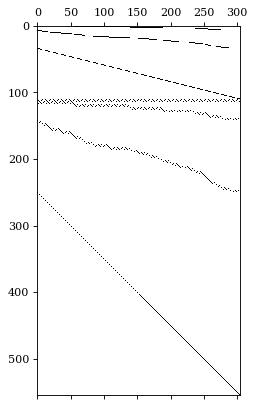

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [ ]:
Y_train_df

,ds,y
unique_id,,
TotalAll,1998-01-01,45151.071280
TotalAll,1998-02-01,17294.699551
TotalAll,1998-03-01,20725.114184
TotalAll,1998-04-01,25388.612353
TotalAll,1998-05-01,20330.035211
...,...,...
GBDOth,2015-08-01,17.683774
GBDOth,2015-09-01,0.000000
GBDOth,2015-10-01,0.000000


### 2.2 StatsForecast's Base Predictions

This cell computes the base predictions `Y_hat_df` for all the series in `Y_df` using StatsForecast's `AutoARIMA`.
Additionally we obtain insample predictions `Y_fitted_df` for the methods that require them.

In [ ]:
%%capture
with CodeTimer('Fit/Predict Model     ', verbose):
    # Read to avoid unnecesary AutoARIMA computation
    yhat_file = f'./data/{dataset}/Y_hat.csv'
    yfitted_file = f'./data/{dataset}/Y_fitted.csv'

    if os.path.exists(yhat_file):
        Y_hat_df = pd.read_csv(yhat_file)
        Y_fitted_df = pd.read_csv(yfitted_file)

        Y_hat_df = Y_hat_df.set_index('unique_id')
        Y_fitted_df = Y_fitted_df.set_index('unique_id')

    else:
        fcst = StatsForecast(
            df=Y_train_df, 
            models=[AutoARIMA(season_length=seasonality)],
            fallback_model=[Naive()],
            freq='M', 
            n_jobs=-1
        )
        Y_hat_df = fcst.forecast(h=horizon, fitted=True, level=LEVEL)
        Y_fitted_df = fcst.forecast_fitted_values()
        Y_hat_df.to_csv(yhat_file)
        Y_fitted_df.to_csv(yfitted_file)

In [ ]:
Y_hat_df

,ds,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,AutoARIMA-lo-84,...,AutoARIMA-hi-80,AutoARIMA-hi-82,AutoARIMA-hi-84,AutoARIMA-hi-86,AutoARIMA-hi-88,AutoARIMA-hi-90,AutoARIMA-hi-92,AutoARIMA-hi-94,AutoARIMA-hi-96,AutoARIMA-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
AAAAll,2015-12-31,2980.2920,2319.5256,2396.95340,2446.0789,2483.0342,2513.0945,2538.6804,2561.1143,2581.2012,...,3344.2986,3361.1145,3379.3828,3399.4695,3421.9036,3447.4895,3477.5496,3514.5050,3563.6304,3641.0583
AAAAll,2016-01-31,1583.3505,906.2675,985.60736,1035.9459,1073.8137,1104.6162,1130.8340,1153.8219,1174.4048,...,1956.3457,1973.5768,1992.2961,2012.8790,2035.8670,2062.0847,2092.8872,2130.7550,2181.0935,2260.4333
AAAAll,2016-02-29,1917.7720,1232.2640,1312.59110,1363.5560,1401.8950,1433.0808,1459.6249,1482.8987,1503.7377,...,2295.4084,2312.8540,2331.8064,2352.6453,2375.9192,2402.4631,2433.6490,2471.9878,2522.9530,2603.2800
AAAAll,2016-03-31,1853.5470,1156.1373,1237.85910,1289.7089,1328.7135,1360.4407,1387.4456,1411.1235,1432.3243,...,2237.7400,2255.4883,2274.7698,2295.9705,2319.6484,2346.6533,2378.3806,2417.3850,2469.2349,2550.9565
AAAAll,2016-04-30,1826.0084,1124.2025,1206.43930,1258.6160,1297.8665,1329.7937,1356.9688,1380.7960,1402.1305,...,2212.6233,2230.4836,2249.8865,2271.2210,2295.0480,2322.2231,2354.1504,2393.4010,2445.5776,2527.8145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TotalVis,2016-07-31,6658.2400,4831.7983,5045.81900,5181.6084,5283.7570,5366.8470,5437.5703,5499.5800,5555.1030,...,7664.4010,7710.8823,7761.3780,7816.9004,7878.9106,7949.6333,8032.7236,8134.8726,8270.6620,8484.6830
TotalVis,2016-08-31,6659.7310,4825.3790,5040.32600,5176.7036,5279.2950,5362.7450,5433.7740,5496.0527,5551.8160,...,7670.2495,7716.9320,7767.6465,7823.4097,7885.6880,7956.7173,8040.1675,8142.7590,8279.1360,8494.0840
TotalVis,2016-09-30,7787.8657,5949.4960,6164.91400,6301.5903,6404.4062,6488.0390,6559.2236,6621.6387,6677.5240,...,8800.5980,8847.3820,8898.2080,8954.0930,9016.5080,9087.6920,9171.3250,9274.1420,9410.8170,9626.2350


In [ ]:
Y_fitted_df

,ds,y,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,...,AutoARIMA-hi-80,AutoARIMA-hi-82,AutoARIMA-hi-84,AutoARIMA-hi-86,AutoARIMA-hi-88,AutoARIMA-hi-90,AutoARIMA-hi-92,AutoARIMA-hi-94,AutoARIMA-hi-96,AutoARIMA-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
AAAAll,1998-01-01,3743.0562,3739.3130,3078.5479,3155.9758,3205.1010,3242.0564,3272.1165,3297.7024,3320.1362,...,4103.3193,4120.1350,4138.4033,4158.4897,4180.9240,4206.5100,4236.5700,4273.5250,4322.6504,4400.0780
AAAAll,1998-02-01,1691.6644,1689.9728,1029.2076,1106.6354,1155.7609,1192.7160,1222.7761,1248.3620,1270.7959,...,2053.9788,2070.7947,2089.0627,2109.1497,2131.5835,2157.1694,2187.2295,2224.1848,2273.3100,2350.7378
AAAAll,1998-03-01,1874.1469,1872.2727,1211.5076,1288.9353,1338.0608,1375.0159,1405.0760,1430.6620,1453.0958,...,2236.2788,2253.0945,2271.3628,2291.4497,2313.8835,2339.4692,2369.5295,2406.4846,2455.6100,2533.0378
AAAAll,1998-04-01,2206.4634,2204.2568,1543.4918,1620.9196,1670.0449,1707.0001,1737.0603,1762.6462,1785.0801,...,2568.2630,2585.0789,2603.3470,2623.4338,2645.8677,2671.4536,2701.5137,2738.4690,2787.5942,2865.0220
AAAAll,1998-05-01,2161.1172,2158.9560,1498.1909,1575.6187,1624.7441,1661.6992,1691.7594,1717.3453,1739.7792,...,2522.9622,2539.7780,2558.0461,2578.1330,2600.5670,2626.1528,2656.2130,2693.1680,2742.2935,2819.7212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TotalVis,2015-08-01,7562.1084,6709.5376,4978.2230,5181.0967,5309.8135,5406.6420,5485.4050,5552.4440,5611.2240,...,7663.2940,7707.3545,7755.2197,7807.8506,7866.6313,7933.6704,8012.4330,8109.2617,8237.9790,8440.8530
TotalVis,2015-09-01,7067.2080,6717.6850,4986.3706,5189.2440,5317.9610,5414.7896,5493.5522,5560.5920,5619.3720,...,7671.4414,7715.5020,7763.3677,7815.9985,7874.7790,7941.8184,8020.5810,8117.4097,8246.1260,8449.0000
TotalVis,2015-10-01,8082.1560,7943.0386,6211.7240,6414.5977,6543.3145,6640.1430,6718.9060,6785.9453,6844.7256,...,8896.7950,8940.8550,8988.7210,9041.3520,9100.1330,9167.1720,9245.9350,9342.7630,9471.4795,9674.3540


## 3. Reconciliate Predictions

In [ ]:
with CodeTimer('Reconcile Predictions ', verbose):
    reconcilers = [
        BottomUp(),
        MinTrace(method='ols'),
        MinTrace(method='wls_var'),
        MinTrace(method='mint_shrink'),
        #ERM(method='reg_bu', lambda_reg=100) # Extremely inneficient
        ERM(method='closed')
    ]
    # hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    # Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df,
    #                          Y_df=Y_fitted_df,
    #                          S=S_df, tags=tags,
    #                          level=LEVEL,
    #                          intervals_method=intervals_method,
    #                          num_samples=10)
    # print('original Y_rec_df.shape', Y_rec_df.shape)
    
    hrec = HierarchicalReconciliation(reconcilers=reconcilers)
    Y_rec_df = hrec.bootstrap_reconcile(Y_hat_df=Y_hat_df,
                                        Y_df=Y_fitted_df,
                                        S_df=S_df, tags=tags,
                                        level=LEVEL,
                                        intervals_method=intervals_method,
                                        num_samples=10, num_seeds=10)

    # Matching Y_test/Y_rec/S index ordering
    Y_test_df = Y_test_df.reset_index()
    Y_test_df.unique_id = Y_test_df.unique_id.astype('category')
    Y_test_df.unique_id = Y_test_df.unique_id.cat.set_categories(S_df.index)
    Y_test_df = Y_test_df.sort_values(by=['unique_id', 'ds'])

    Y_rec_df = Y_rec_df.reset_index()
    Y_rec_df.unique_id = Y_rec_df.unique_id.astype('category')
    Y_rec_df.unique_id = Y_rec_df.unique_id.cat.set_categories(S_df.index)
    Y_rec_df = Y_rec_df.sort_values(by=['seed', 'unique_id', 'ds'])

    # Parsing model level columns
    flat_cols = list(hrec.level_names.keys())
    for model in hrec.level_names:
        flat_cols += hrec.level_names[model]
    for model in hrec.sample_names:
        flat_cols += hrec.sample_names[model]
    y_rec  = Y_rec_df[flat_cols]
    model_columns = y_rec.columns

    n_series = len(S_df)
    n_seeds = len(Y_rec_df.seed.unique())
    y_rec  = y_rec.values.reshape(n_seeds, n_series, horizon, len(model_columns))
    y_test = Y_test_df['y'].values.reshape(n_series, horizon)
    y_train = Y_train_df['y'].values.reshape(n_series, -1)

Code block 'Reconcile Predictions ' took:	32.79007 seconds


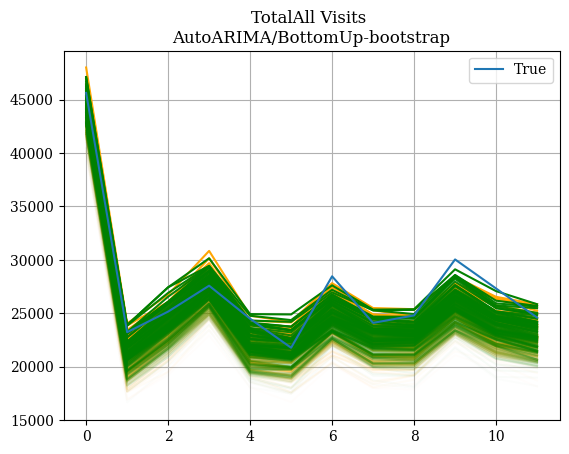

In [ ]:
# Qualitative evaluation, of parsed quantiles
row_idx = 0
seed_idx = 0
col_idxs = model_columns.get_indexer(hrec.level_names['AutoARIMA/BottomUp'])
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[seed_idx, row_idx,:,col], color='orange', alpha=i/100)
for i, col in enumerate(col_idxs):
    plt.plot(y_rec[seed_idx+1, row_idx,:,col], color='green', alpha=i/100)
plt.plot(y_test[row_idx,:], label='True')
plt.title(f'{S_df.index[row_idx]} Visits \n' + \
          f'AutoARIMA/BottomUp-{intervals_method}')

plt.legend()
plt.grid()
plt.show()
plt.close()

In [ ]:
Y_rec_df

,unique_id,ds,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,...,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-1,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-2,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-3,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-4,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-5,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-6,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-7,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-8,AutoARIMA/ERM_method-closed_lambda_reg-0.01-sample-9,seed
0,TotalAll,2015-12-31,46343.890,42610.426000,43047.910000,43325.477000,43534.280000,43704.130000,43848.695000,43975.453000,...,45336.914062,47602.257812,48302.019531,44153.992188,48077.589844,43754.773438,44431.507812,42548.394531,41829.566406,0
1,TotalAll,2016-01-31,21098.996,17348.574000,17788.045000,18066.875000,18276.627000,18447.244000,18592.467000,18719.799000,...,22860.847656,20799.388672,22996.707031,20032.830078,24584.890625,22747.904297,22817.082031,20317.691406,24704.429688,0
2,TotalAll,2016-02-29,24797.059,20985.898000,21432.486000,21715.832000,21928.982000,22102.363000,22249.938000,22379.330000,...,26002.437500,25910.949219,31082.023438,26421.435547,29042.490234,27756.875000,26153.490234,25305.375000,24591.416016,0
3,TotalAll,2016-03-31,29107.896,25242.193000,25695.172000,25982.572000,26198.773000,26374.635000,26524.322000,26655.568000,...,30581.591797,28916.650391,32972.722656,30255.710938,29247.755859,27408.404297,29333.947266,24495.794922,27627.130859,0
4,TotalAll,2016-04-30,23126.271,19206.299000,19665.637000,19957.072000,20176.309000,20354.639000,20506.428000,20639.516000,...,24487.552734,24391.300781,26764.310547,24469.664062,27584.904297,24860.736328,23234.486328,27196.103516,24463.337891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66595,GBDOth,2016-07-31,0.000,-6.472827,-5.714347,-5.233117,-4.871106,-4.576638,-4.325999,-4.106238,...,9.147546,3.887892,10.285013,16.461996,8.306333,13.134643,6.387368,9.335155,3.198929,9
66596,GBDOth,2016-08-31,0.000,-6.472827,-5.714347,-5.233117,-4.871106,-4.576638,-4.325999,-4.106238,...,2.904406,-2.086869,3.251205,3.390686,-8.689140,-6.417166,2.923086,2.249920,-5.544720,9
66597,GBDOth,2016-09-30,0.000,-6.472827,-5.714347,-5.233117,-4.871106,-4.576638,-4.325999,-4.106238,...,-4.809000,-0.237515,5.609873,-1.117550,-0.323714,-4.081538,-6.096592,-6.997902,-2.014737,9
66598,GBDOth,2016-10-31,0.000,-6.472827,-5.714347,-5.233117,-4.871106,-4.576638,-4.325999,-4.106238,...,-0.218271,-3.023609,-14.384845,5.987271,-3.726561,-1.460724,-8.328702,-18.018049,0.033308,9


## 4. Evaluation

In [ ]:
with CodeTimer('Evaluate Models CRPS  ', verbose):
    crps_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                    'Level': ['Overall'] + list(tags.keys()),}

    for model in hrec.level_names.keys():
        crps_results[model] = []
        for level in crps_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(hrec.level_names[model])
            _y = y_test[row_idxs,:]
            _y_rec_seeds = y_rec[:,row_idxs,:,:][:,:,:,col_idxs]

            level_model_crps =[]
            for seed_idx in range(y_rec.shape[0]):
                _y_rec = _y_rec_seeds[seed_idx,:,:,:]
                level_model_crps.append(scaled_crps(y=_y, y_hat=_y_rec,
                                                    quantiles=QUANTILES))
            level_model_crps = f'{np.mean(level_model_crps):.4f} ± {(1.96 * np.std(level_model_crps)):.4f}'
            crps_results[model].append(level_model_crps)

    crps_results = pd.DataFrame(crps_results)

crps_results

Code block 'Evaluate Models CRPS  ' took:	6.16767 seconds


,Dataset,Level,AutoARIMA/BottomUp,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,TourismLarge,Overall,0.1423 ± 0.0013,0.1317 ± 0.0008,0.1345 ± 0.0010,0.1307 ± 0.0009,0.1472 ± 0.0007
1,TourismLarge,Country,0.0698 ± 0.0026,0.0278 ± 0.0011,0.0545 ± 0.0020,0.0455 ± 0.0017,0.0300 ± 0.0010
2,TourismLarge,Country/State,0.0873 ± 0.0018,0.0622 ± 0.0010,0.0759 ± 0.0013,0.0707 ± 0.0011,0.0715 ± 0.0008
3,TourismLarge,Country/State/Zone,0.1260 ± 0.0010,0.1148 ± 0.0008,0.1180 ± 0.0008,0.1146 ± 0.0007,0.1262 ± 0.0009
4,TourismLarge,Country/State/Zone/Region,0.1696 ± 0.0007,0.1690 ± 0.0007,0.1633 ± 0.0007,0.1603 ± 0.0006,0.1835 ± 0.0013
5,TourismLarge,Country/Purpose,0.0844 ± 0.0019,0.0750 ± 0.0014,0.0759 ± 0.0017,0.0702 ± 0.0014,0.0819 ± 0.0010
6,TourismLarge,Country/State/Purpose,0.1307 ± 0.0016,0.1224 ± 0.0013,0.1250 ± 0.0015,0.1225 ± 0.0013,0.1393 ± 0.0010
7,TourismLarge,Country/State/Zone/Purpose,0.1987 ± 0.0009,0.1983 ± 0.0009,0.1941 ± 0.0008,0.1927 ± 0.0007,0.2260 ± 0.0012
8,TourismLarge,Country/State/Zone/Region/Purpose,0.2719 ± 0.0008,0.2843 ± 0.0009,0.2696 ± 0.0007,0.2691 ± 0.0007,0.3194 ± 0.0015


In [ ]:
with CodeTimer('Evaluate Models MSSE  ', verbose):
    msse_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                    'Level': ['Overall'] + list(tags.keys()),}
    for model in hrec.level_names.keys():
        msse_results[model] = []
        for level in msse_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idx = model_columns.get_loc(model)
            _y = y_test[row_idxs,:]
            _y_train = y_train[row_idxs,:]
            _y_hat_seeds = y_rec[:,row_idxs,:,:][:,:,:,col_idx]

            level_model_msse = []
            for seed_idx in range(y_rec.shape[0]):
                _y_hat = _y_hat_seeds[seed_idx,:,:]
                level_model_msse.append(msse(y=_y, y_hat=_y_hat, y_train=_y_train))
            level_model_msse = f'{np.mean(level_model_msse):.4f} ± {(1.96 * np.std(level_model_msse)):.4f}'
            msse_results[model].append(level_model_msse)

    msse_results = pd.DataFrame(msse_results)

msse_results

Code block 'Evaluate Models MSSE  ' took:	4.18719 seconds


,Dataset,Level,AutoARIMA/BottomUp,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,TourismLarge,Overall,0.3393 ± 0.0000,0.1074 ± 0.0000,0.1757 ± 0.0000,0.1409 ± 0.0000,0.1204 ± 0.0000
1,TourismLarge,Country,0.4874 ± 0.0000,0.0422 ± 0.0000,0.1939 ± 0.0000,0.1321 ± 0.0000,0.0416 ± 0.0000
2,TourismLarge,Country/State,0.4012 ± 0.0000,0.1091 ± 0.0000,0.1949 ± 0.0000,0.1587 ± 0.0000,0.1387 ± 0.0000
3,TourismLarge,Country/State/Zone,0.4403 ± 0.0000,0.2748 ± 0.0000,0.3001 ± 0.0000,0.2742 ± 0.0000,0.3180 ± 0.0000
4,TourismLarge,Country/State/Zone/Region,0.4180 ± 0.0000,0.3665 ± 0.0000,0.3385 ± 0.0000,0.3244 ± 0.0000,0.4044 ± 0.0000
5,TourismLarge,Country/Purpose,0.1796 ± 0.0000,0.0796 ± 0.0000,0.0992 ± 0.0000,0.0776 ± 0.0000,0.0780 ± 0.0000
6,TourismLarge,Country/State/Purpose,0.2060 ± 0.0000,0.1328 ± 0.0000,0.1477 ± 0.0000,0.1356 ± 0.0000,0.1570 ± 0.0000
7,TourismLarge,Country/State/Zone/Purpose,0.3097 ± 0.0000,0.2626 ± 0.0000,0.2670 ± 0.0000,0.2571 ± 0.0000,0.3383 ± 0.0000
8,TourismLarge,Country/State/Zone/Region/Purpose,0.3735 ± 0.0000,0.3608 ± 0.0000,0.3503 ± 0.0000,0.3454 ± 0.0000,0.4398 ± 0.0000


In [ ]:
with CodeTimer('Evaluate Models EScore', verbose):
    energy_results = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
                        'Level': ['Overall'] + list(tags.keys()),}
    for model in hrec.sample_names.keys():
        energy_results[model] = []
        for level in energy_results['Level']:
            if level=='Overall':
                row_idxs = np.arange(len(S_df))
            else:
                row_idxs = S_df.index.get_indexer(tags[level])
            col_idxs = model_columns.get_indexer(hrec.sample_names[model])
            _y = y_test[row_idxs,:]
            _y_sample1 = y_rec[0,row_idxs,:,:][:,:,col_idxs[:len(col_idxs)//2]]
            _y_sample2 = y_rec[0,row_idxs,:,:][:,:,col_idxs[len(col_idxs)//2:]]
            level_model_energy = energy_score(y=_y, 
                                              y_sample1=_y_sample1,
                                              y_sample2=_y_sample2,
                                              beta=2)
            energy_results[model].append(level_model_energy)
    energy_results = pd.DataFrame(energy_results)

energy_results

Code block 'Evaluate Models EScore' took:	1.25262 seconds


,Dataset,Level,AutoARIMA/BottomUp,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-wls_var,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/ERM_method-closed_lambda_reg-0.01
0,TourismLarge,Overall,2.266531e+07,1.491245e+07,1.775047e+07,1.603668e+07,1.720387e+07
1,TourismLarge,Country,8.048029e+06,2.359581e+06,5.042403e+06,4.019710e+06,2.202401e+06
2,TourismLarge,Country/State,2.659830e+06,1.327614e+06,1.832337e+06,1.642296e+06,1.989778e+06
3,TourismLarge,Country/State/Zone,1.701113e+06,1.391248e+06,1.401339e+06,1.346430e+06,1.761459e+06
4,TourismLarge,Country/State/Zone/Region,1.398248e+06,1.351556e+06,1.258046e+06,1.230904e+06,1.662631e+06
5,TourismLarge,Country/Purpose,4.373046e+06,4.186007e+06,3.964894e+06,3.600118e+06,4.155193e+06
6,TourismLarge,Country/State/Purpose,1.830505e+06,1.714823e+06,1.708184e+06,1.672776e+06,2.155924e+06
7,TourismLarge,Country/State/Zone/Purpose,1.385461e+06,1.315922e+06,1.308938e+06,1.294696e+06,1.701534e+06
8,TourismLarge,Country/State/Zone/Region/Purpose,1.269074e+06,1.265704e+06,1.234331e+06,1.229754e+06,1.574945e+06


## References

- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
\"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2022). 
"Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". 
Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)